# apo05 Workflow Demo
This is the demo data we've used a lot... it's originally from SLH, used to teach APO observing class for years!

Use it to debug all the functions, flush out the slightly updated workflow

Not a robust tutorial, but useful!

In [1]:
 # need notebook backend for interaction
# %matplotlib inline
# notebook

import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u

# import kosmos... if we do it right this should be the only other thing to import someday!
import sys  
sys.path.append('..')

import kosmos
kosmos.__version__

'0.1'

In [2]:
# should we make a whole bunch of plots?
DISPLAY = True

## 1. Bias

In [3]:
# to run on data, the user should provide lists of files to reduce.
# we can do this via the old IRAF way for now (b/c I'm old fashioned),
# but probably could design a more pythonic way (e.g. w/ glob or similar)
import glob
biasfiles = glob.glob("../testdata/bias*.fits")

# dir = '../kosmos/testdata/slh05_test/apo05/'
# biasfiles_i = pd.read_table(dir + 'biaslist.txt', names=['impath'])
# biasfiles = dir + biasfiles_i['impath'].values
biasfiles

['../testdata/bias.0003.fits',
 '../testdata/bias.0002.fits',
 '../testdata/bias.0005.fits',
 '../testdata/bias.0004.fits',
 '../testdata/bias.0001.fits']

In [4]:
# use simple wrapper for median bias combining
bias = kosmos.biascombine(biasfiles) 
print(bias.shape)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(bias, origin='lower', aspect='auto', cmap=plt.cm.gray)
    plt.title('median bias frame')
    plt.clim(np.percentile(bias, (5, 98)))
    cb = plt.colorbar()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(2048, 1124)


/Users/catrionamurray/opt/anaconda3/envs/kosmos/lib/python3.9/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


## 2. Flat

In [5]:
# flatfiles_i = pd.read_table(dir + 'flatlist.txt', names=['impath'])
# flatfiles = dir + flatfiles_i['impath'].values
flatfiles = glob.glob("../testdata/*quartz*.fits")
flatfiles

['../testdata/red-7.1-ctr-quartz.0043.fits',
 '../testdata/red-7.1-ctr-quartz.0042.fits',
 '../testdata/red-7.1-ctr-quartz.0049.fits',
 '../testdata/red-7.1-ctr-quartz.0045.fits',
 '../testdata/red-7.1-ctr-quartz.0044.fits',
 '../testdata/red-7.1-ctr-quartz.0048.fits',
 '../testdata/red-7.1-ctr-quartz.0047.fits',
 '../testdata/red-7.1-ctr-quartz.0051.fits',
 '../testdata/red-7.1-ctr-quartz.0050.fits',
 '../testdata/red-7.1-ctr-quartz.0046.fits']

[[662.0 458.0 519.0 ... 79.0 58.0 34.0]
 [494.0 690.0 681.0 ... 61.0 56.0 67.0]
 [577.0 571.0 650.0 ... 57.0 59.0 68.0]
 ...
 [191.0 235.0 246.0 ... 4.0 8.0 22.0]
 [250.0 213.0 277.0 ... 27.0 12.0 12.0]
 [232.0 238.0 226.0 ... 24.0 24.0 -4.0]]


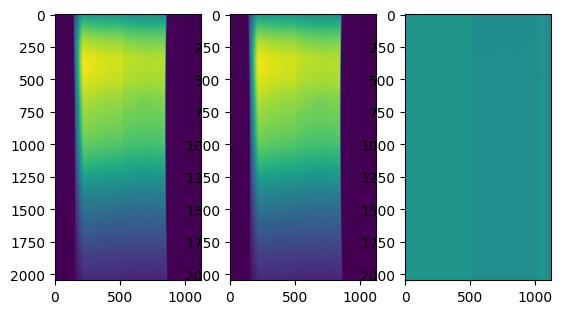

In [6]:
from astropy.io import fits

with fits.open(flatfiles[0]) as hdulist:
    print(hdulist[0].data - bias)
    fig, ax = plt.subplots(ncols=3)
    
    ax[0].imshow(hdulist[0].data)
#     plt.colorbar()
    ax[1].imshow(hdulist[0].data - bias)
#     plt.colorbar()
    plt3 = ax[2].imshow(bias)
#     plt.colorbar(plt3)
    

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


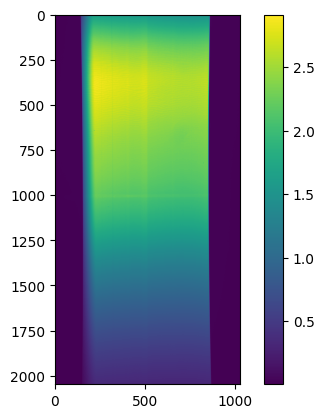

In [7]:
from ccdproc import CCDData,Combiner
from kosmos.imtools import proc
# img = CCDData.read(flatfiles[0 ], unit=u.adu)
img0 = proc(flatfiles[0], bias=bias, EXPTIME='EXPTIME', DATASEC='DATASEC', datasection="[1:1024,1:2048]", trim=True)
img1 = proc(flatfiles[1], bias=bias, EXPTIME='EXPTIME', DATASEC='DATASEC', datasection="[1:1024,1:2048]", trim=True)
img0.data = img0.data/np.nanmedian(img0.data)
img1.data = img1.data/np.nanmedian(img1.data)
plt.imshow(img0.data)
plt.colorbar()
plt.show()

medflat = Combiner([img0,img1]).median_combine()
plt.imshow(medflat)
plt.colorbar()
plt.show()
# img.data

In [8]:
# a wrapper around Combiner, the spectral response normalization, and the illumination correction
# this should work WITH or WITHOUT a bias given
flat, ilum = kosmos.flatcombine(flatfiles, bias=bias, DATASEC="DSEC11", Saxis=1, Waxis=0) 

print(ilum.shape) # this is the indicies that are illuminated
print(flat.shape)
print(flat.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(flat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median flat, bias & response corrected')
    cb = plt.colorbar()

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecat

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecat

/Users/catrionamurray/opt/anaconda3/envs/kosmos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(651,)
(2048, 651)
adu / s


 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecat

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecat

(2048, 1024)
adu / s


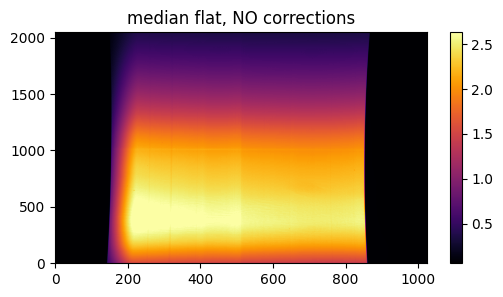

In [9]:
# if you turn off the illumination and response corrections, you just get a normalized median combined image
# i.e. could be used for photometry
medflat = kosmos.flatcombine(flatfiles, illumcor=False, responsecor=False, DATASEC="DSEC11", Saxis=1, Waxis=0)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(medflat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(np.percentile(medflat, (5, 98)))
    plt.title('median flat, NO corrections')
    cb = plt.colorbar()

print(medflat.shape)
print(medflat.unit)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/catrionamurray/opt/anaconda3/envs/kosmos/lib/python3.9/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


(2048, 651)
adu / s


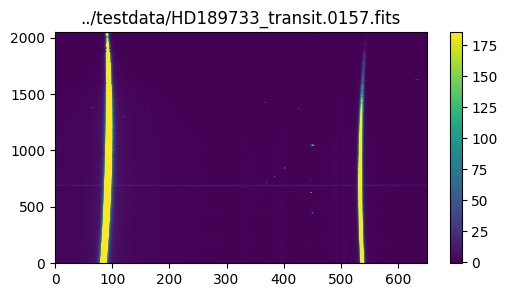

In [10]:
# how to read in any science or calibration frame w/ a spectrum present
sci = glob.glob("../testdata/*transit*.fits")[0]

# sci = dir + '05may31.0010r.fits'  # spectrum of the one target star, Gl 669A
sciimg = kosmos.proc(sci, bias=bias, ilum=ilum, flat=flat, DATASEC="DSEC11", datasection="[1:1024,1:2048]", trim=True, Saxis=1, Waxis=0)

print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(sciimg, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(sci)

In [40]:
# fcal = dir + '05may31.0020r.fits' # Flux std star observation, BD+282411
fcal = glob.glob("../testdata/HR7596*.fits")[0]

calimg = kosmos.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=True, DATASEC="DSEC11", datasection="[1:1024,1:2048]",Saxis=1, Waxis=0)
print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(calimg, origin='lower', aspect='auto', cmap=plt.cm.Spectral_r)
    plt.clim(np.percentile(calimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(fcal)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(2048, 651)
adu / s


/Users/catrionamurray/opt/anaconda3/envs/kosmos/lib/python3.9/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


## 4. Trace & Extract

/Users/catrionamurray/opt/anaconda3/envs/kosmos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


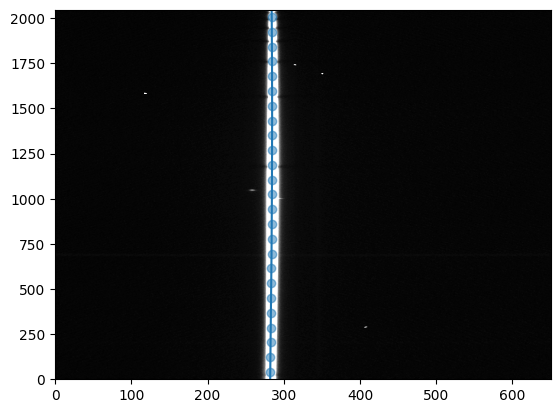

(2048,)

In [41]:
cal_trace = kosmos.trace(calimg, display=DISPLAY, nbins=25, Saxis=1, Waxis=0)
sci_trace = kosmos.trace(sciimg, display=True, nbins=55, Saxis=1, Waxis=0)

sci_trace.shape

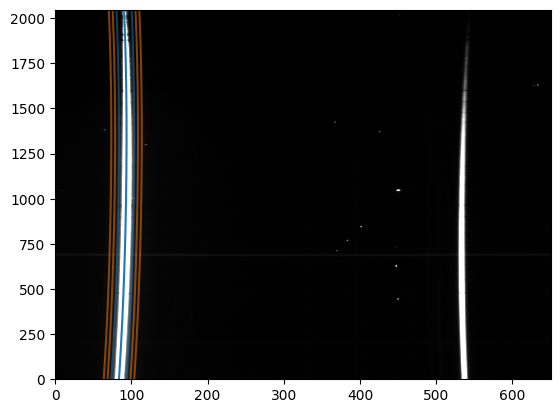

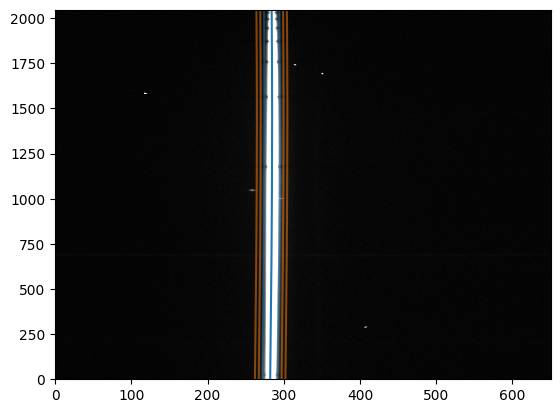

In [43]:
sci_ex, sci_sky = kosmos.BoxcarExtract(sciimg, sci_trace, display=DISPLAY, apwidth=10, skysep=5, skywidth=5, Saxis=1, Waxis=0)
cal_ex, cal_sky = kosmos.BoxcarExtract(calimg, cal_trace, display=True, apwidth=10, skysep=5, skywidth=5, Saxis=1, Waxis=0)

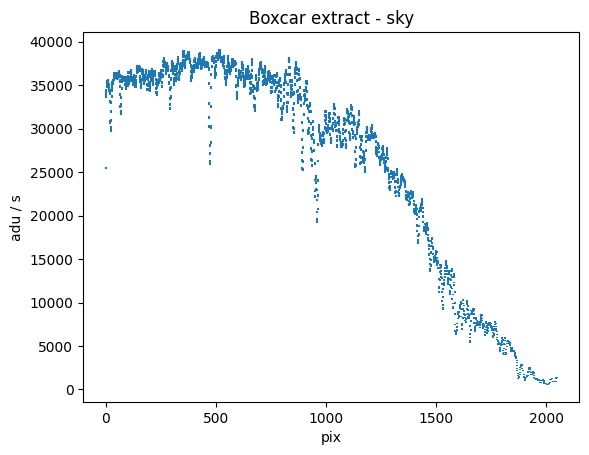

In [14]:
if DISPLAY:
    plt.errorbar(sci_ex.spectral_axis.value, sci_ex.flux.value - sci_sky.flux.value, 
                 yerr=sci_ex.uncertainty.array, linestyle='none')
    plt.xlabel(sci_ex.spectral_axis.unit)
    plt.ylabel(sci_ex.flux.unit)
    plt.title('Boxcar extract - sky')

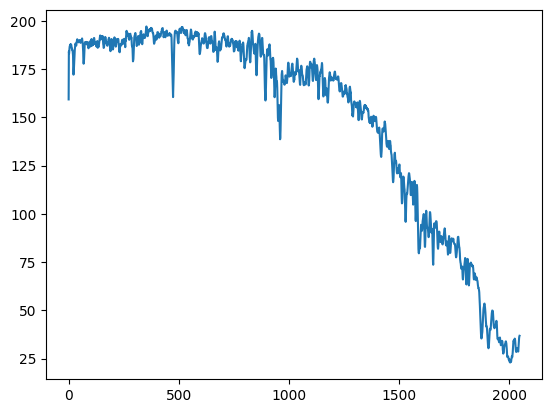

In [38]:
plt.plot(sci_ex.spectral_axis.value, (sci_ex.flux.value-sci_sky.flux.value)/sci_ex.uncertainty.array)

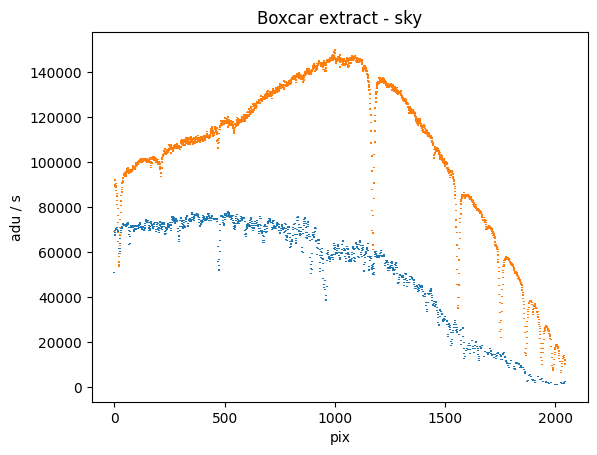

In [58]:
if DISPLAY:
    plt.errorbar(sci_ex.spectral_axis.value, 2*(sci_ex.flux.value - sci_sky.flux.value), 
                 yerr=sci_ex.uncertainty.array, linestyle='none')
    plt.errorbar(cal_ex.spectral_axis.value, cal_ex.flux.value - cal_sky.flux.value, 
                 yerr=cal_ex.uncertainty.array, linestyle='none')
    plt.xlabel(cal_ex.spectral_axis.unit)
    plt.ylabel(cal_ex.flux.unit)
    plt.title('Boxcar extract - sky')

In [39]:
sci_ex.flux

<Quantity [25576.09965343, 34133.89176185, 33920.82602837, ...,
            1291.66156562,  1359.84126415,  1367.99453193] adu / s>

## 5. Wavelength Calibration
This is (in my opinion) the hardest part of the entire pipeline.

In [24]:
len(sci_trace)

2048

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/catrionamurray/opt/anaconda3/envs/kosmos/lib/python3.9/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


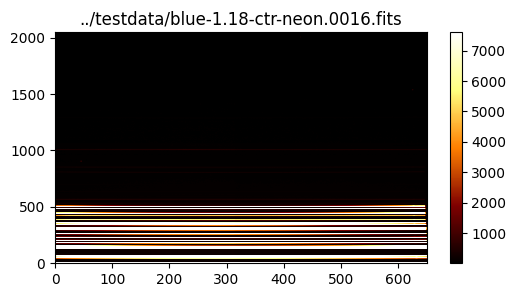

In [22]:
# arcfile = dir + '05may31.0035r.fits' # HeNeAr lamp
neonfile = glob.glob("../testdata/*neon*.fits")[0]
# read and process in the ARC LAMP, just like a normal spectrum
arcimg = kosmos.proc(neonfile, bias=bias, ilum=ilum, trim=True, DATASEC="DSEC11", datasection="[1:1024,1:2048]", Saxis=1, Waxis=0) 

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(arcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
    plt.plot(np.arange(len(sci_trace)), sci_trace) # for illustration, overplot the trace 
    plt.clim(np.percentile(arcimg, (5, 97)))
    cb = plt.colorbar()
    plt.title(neonfile)

In [29]:
# sciimg.header

In [28]:
# # this data comes from the APO DIS red channel, which has wavelength axis backwards
# # (despite not mentioning in the header...)
# wapprox = (np.arange(sciimg.shape[1]) - sciimg.shape[1]/2)[::-1] * sciimg.header['DISPDW'] + sciimg.header['DISPWC']
# wapprox = wapprox * u.angstrom

# if DISPLAY:
#     plt.errorbar(wapprox.value, sci_ex.flux.value - sci_sky.flux.value, 
#                  yerr=sci_ex.uncertainty.array, linestyle='none')
#     plt.xlabel(wapprox.unit)
#     plt.ylabel(sci_ex.flux.unit)
#     plt.title('Boxcar extract - sky')

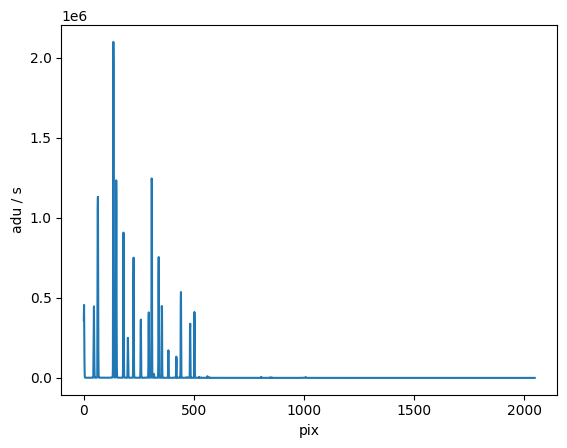

In [44]:
# extract the trace across the Arc lamp image
sciarc_ex, _ = kosmos.BoxcarExtract(arcimg, sci_trace, apwidth=3, skysep=5, skywidth=5, Saxis=1, Waxis=0)
calarc_ex, _ = kosmos.BoxcarExtract(arcimg, cal_trace, apwidth=3, skysep=5, skywidth=5, Saxis=1, Waxis=0)

if DISPLAY:
    plt.plot(sciarc_ex.spectral_axis.value, sciarc_ex.flux.value)
    plt.xlabel(sciarc_ex.spectral_axis.unit)
    plt.ylabel(sciarc_ex.flux.unit)

# plt.ylim(-10,85)
# wow... so many little features here that could be used by DTW!

In [18]:
# a table of strong HeNeAr lines for the instrument in question, w/ units
# apo_henear = Table.read(dir+'apohenear.ecsv', format='ascii.ecsv')['wave']


# The old IRAF-style linelists just have 2 col: (wavelength, line name)
henear_tbl = Table.read('../kosmos/resources/linelists/apohenear.dat', 
                        names=('wave', 'name'), format='ascii')
# IMPROVEMENT NEEDED: need to make `identify_nearest` point to these linelists itself?

henear_tbl['wave'].unit = u.angstrom
apo_henear = henear_tbl['wave']


In [19]:
# use the "nearest" mode, which uses a list of known line features, and the
# approx wavelength from the header info. Starts in the middle, tries to find nearest
# peaks to those in the catalog... it works ok-ish for some modes

sci_xpts, sci_wpts = kosmos.identify_nearest(sciarc_ex, wapprox=wapprox, linewave=apo_henear, autotol=5)

19 lines matched from 20 within estimated range.


In [20]:
sci_xpts

array([ 359.69912256,  398.79510201,  520.98210502,  771.86347869,
        817.57534447,  910.88307912,  988.59453671, 1019.59957675,
       1142.25699226, 1164.91233446, 1222.06047995, 1256.94943369,
       1302.04323081, 1360.01756229, 1423.34840306, 1447.58899816,
       1503.00022427, 1528.79898629, 1764.5435791 ])

In [48]:
# subtract the sky from the actual spectrum
cal_spectrum = cal_ex - cal_sky
sci_spectrum = sci_ex - sci_sky

UnitTypeError: SpectralCoord instances require units equivalent to '(Unit("Hz"), Unit("m"), Unit("J"), Unit("1 / m"), Unit("km / s"))', so cannot set it to 'pix'.

<IPython.core.display.Javascript object>


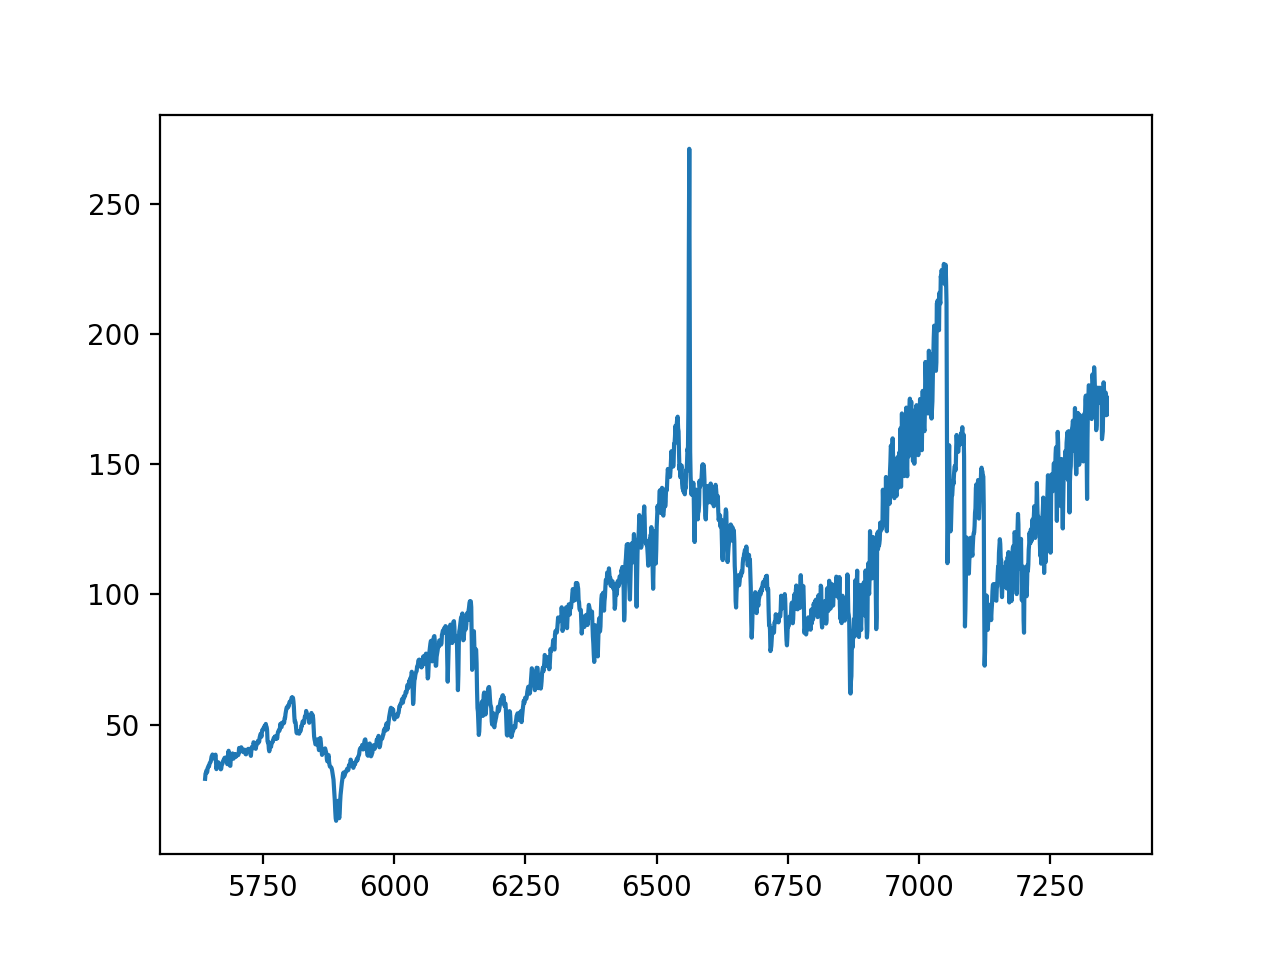

In [22]:
cal_fit = kosmos.fit_wavelength(cal_spectrum, sci_xpts, sci_wpts, mode='interp', deg=3)
sci_fit = kosmos.fit_wavelength(sci_spectrum, sci_xpts, sci_wpts, mode='interp', deg=3)

if DISPLAY:
    plt.plot(sci_fit.spectral_axis, sci_fit.flux)

## 4. Airmass & Flux Calibration

In [45]:
# Get the airmass from the Headers... no fancy way to do this I guess? 
ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)

print(sci_airmass, cal_airmass)

1.142021913884223 2.8886688576908184


In [46]:
# Select the observatory-specific airmass extinction profile from the provided "extinction" library
Xfile = kosmos.obs_extinction('apoextinct.dat')
# Xfile

In [53]:
# apply the airmass correction
cal_fitX = kosmos.airmass_cor(cal_fit, cal_airmass, Xfile)
sci_fitX = kosmos.airmass_cor(sci_fit, sci_airmass, Xfile)

In [26]:
# Select the Standard Star reference spectrum from the provided "onedstd" library
standardstar = kosmos.onedstd('spec50cal/bd284211.dat')
# standardstar

<IPython.core.display.Javascript object>


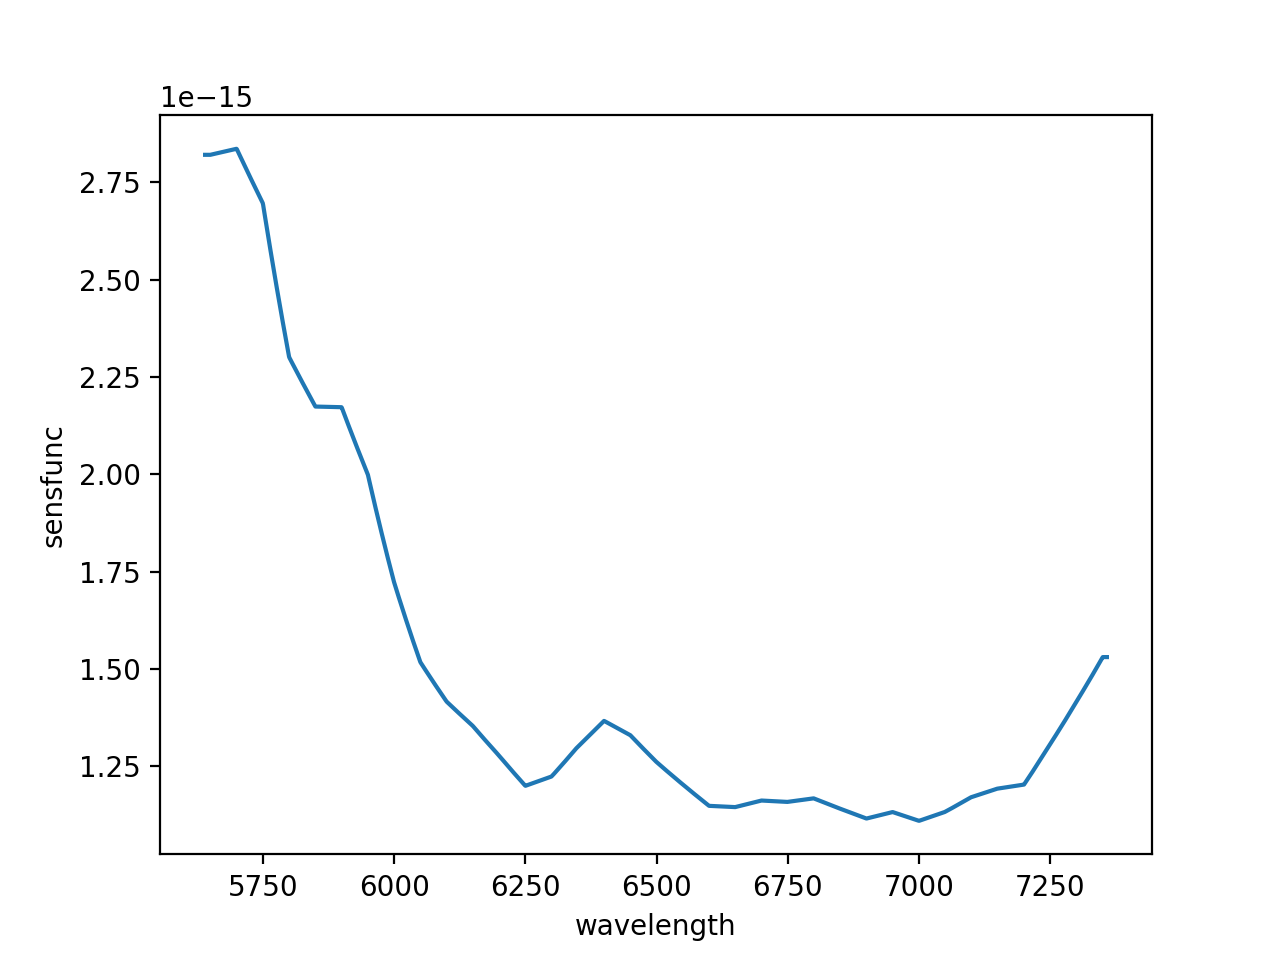

Unit("erg / (adu Angstrom cm2)")

In [27]:
# this is the sensitivity function, which converts the CCD data from
# ADU/S -> erg/s/cm2/A
sensfunc = kosmos.standard_sensfunc(cal_fitX, standardstar, mode='linear', display=False)

if DISPLAY:
    plt.plot(sensfunc.spectral_axis, sensfunc.flux)
    plt.xlabel('wavelength')
    plt.ylabel('sensfunc')
    
sensfunc.flux.unit

In [29]:
# convert from air to vac wavelength

# sci_fitX = kosmos.air_to_vac(sci_fitX)

<IPython.core.display.Javascript object>


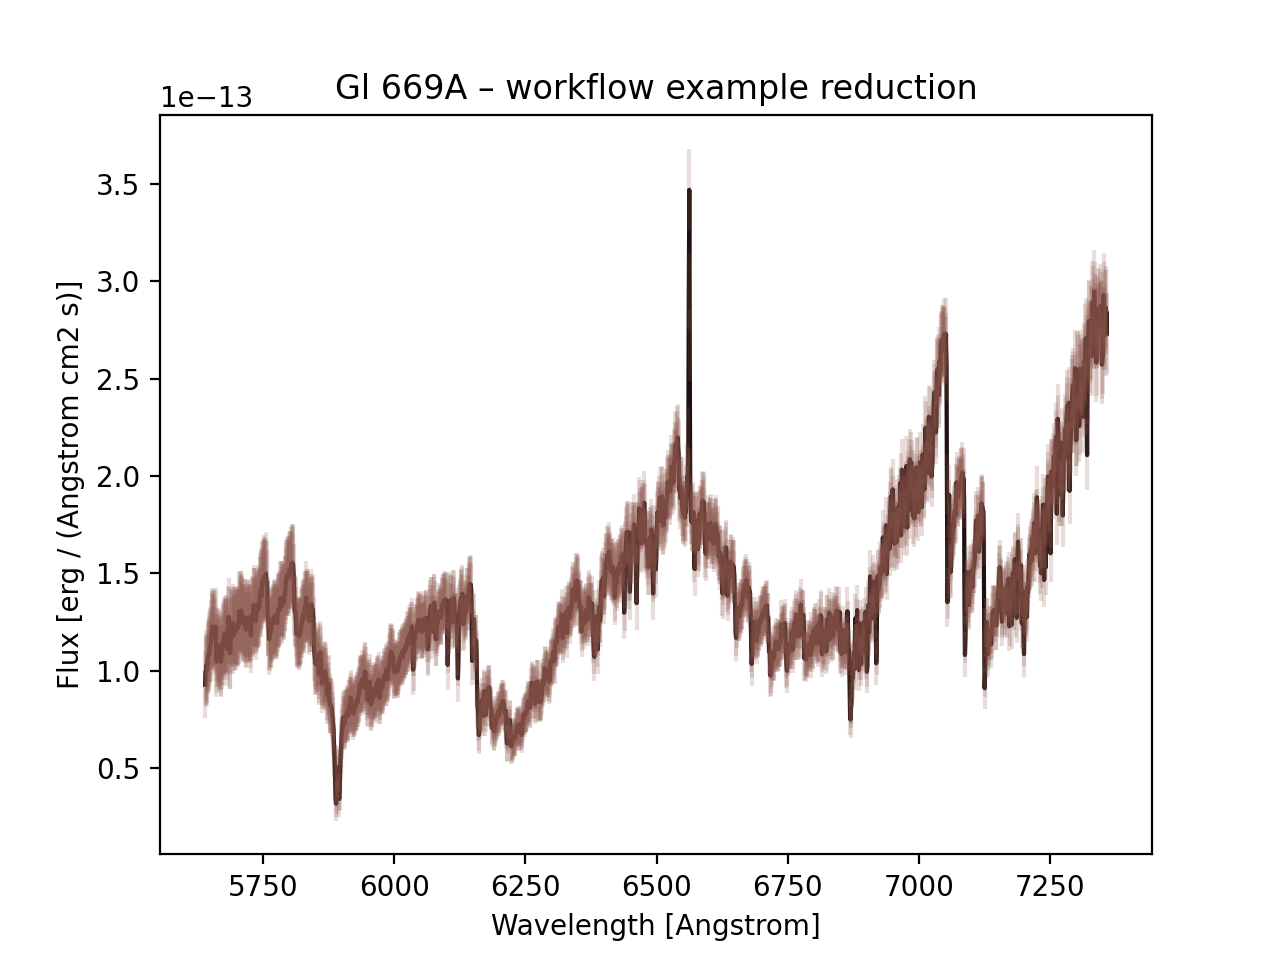

Unit("erg / (Angstrom cm2 s)")

In [28]:
final_spectrum = kosmos.apply_sensfunc(sci_fitX, sensfunc)

if DISPLAY:
    plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='k')

    # having to convert the Spectrum1D parameters like this is annoying,
    # and also inconsistent behavior with the uncertainty
    plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
                 yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

    plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
    plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
    plt.title('Gl 669A – workflow example reduction')
    
final_spectrum.flux.unit # units check out!

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


<IPython.core.display.Javascript object>


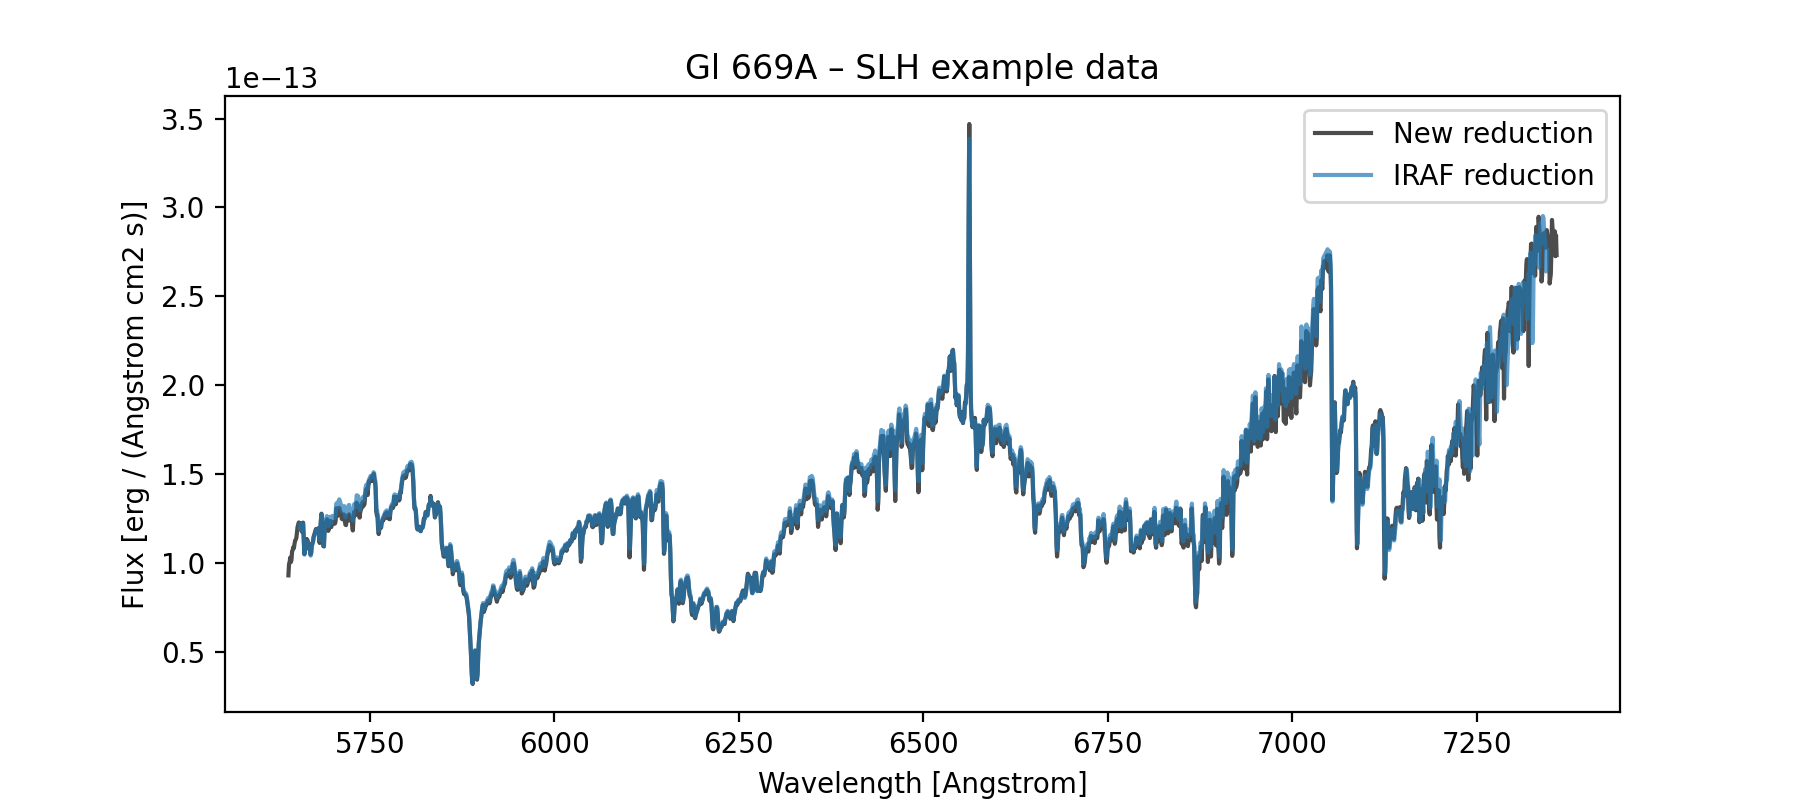

In [30]:
# Read in the IRAF-reduced version!
from astropy.nddata import CCDData
# dir = '../kosmos/testdata/slh05_test/apo05/'
img = CCDData.read('../kosmos/testdata/slh05_test/slh_reduction/gl669cal.fits', hdu=0)
# img.wcs

plt.figure(figsize=(9,4))
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='k', label='New reduction', alpha=0.7)

# having to convert the Spectrum1D parameters like this is annoying
# and also inconsistent behavior with the uncertainty
# plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
#              yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

# coefficients manually taken from the WCS info in the header, 
# b/c I can't figure out how to access them progamatically...
plt.plot(5654.8668211415 + np.arange(2006)*0.84311144412739, img.data[0,0,:], 
         label='IRAF reduction', alpha=.7)

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – SLH example data')
plt.legend()

In [ ]:
# TO DO: might want to also add Telluric Correction, examples with TelFit...
# https://telfit.readthedocs.io/en/latest/